# kc-macd-anti-trend
- same kc anti-trend
- with modified macd 3 10 16, by end of hour 4 where T 1 2 3 4, where T is trade hour, macd must have crossed to other side, else liquidate without question. Set 1 day time stop. 
- if after hour 4 and macd crosses to wrong direction, liquidate without question
- measure profit/loss by % tp/sl line. If reached, then 1, if halfway to stop loss, then -0.5, etc.

In [1]:
from binance.client import Client
from downloader import Downloader
import matplotlib.pyplot as plt
dl = Downloader()
import pandas as pd
import time
from datetime import datetime
import numpy as np
import statsmodels.formula.api as sm
import math
import seaborn as sns
import metalabeller as ml
import ta
import macdtester as t

In [310]:
df = dl.get_working_data("DOGEUSDT", span="m")
# dfh = dl.get_working_data("BTCUSDT", span="h")

## Functions

In [311]:
def get_kc(high, low, close, kc_lookback, multiplier, atr_lookback):
    tr1 = pd.DataFrame(high - low)
    tr2 = pd.DataFrame(abs(high - close.shift()))
    tr3 = pd.DataFrame(abs(low - close.shift()))
    frames = [tr1, tr2, tr3]
    tr = pd.concat(frames, axis = 1, join = 'inner').max(axis = 1)
    atr = tr.ewm(alpha = 1/atr_lookback).mean()
    
    kc_middle = close.ewm(kc_lookback).mean()
    kc_upper = close.ewm(kc_lookback).mean() + multiplier * atr
    kc_lower = close.ewm(kc_lookback).mean() - multiplier * atr
    
    return kc_middle, kc_upper, kc_lower
    
# For metadata
def get_kc_events(df, events, stats, funcs, l1=1, l2=3, l3=7):
    """
    stats = ['gain', v0'...]
    funcs = [func_1, func_2...], needs to be same length as stats
    l1, l2, l3 are lengths from t0-days:t0. 
    All funcs need to have signature func(df_1, df_7, df_30)->float
    
    Returns macd events, dropped nans. 
    """
    if len(stats) != len(funcs): raise Exception
    result = pd.DataFrame(np.nan, index=events.index, columns=stats)

    for i in range(len(events)):
        t0 = events.index[i]
        if t0-pd.Timedelta(days=l3) not in df.index: continue
        df_1 = df.loc[t0-pd.Timedelta(days=l1):t0]
        df_2 = df.loc[t0-pd.Timedelta(days=l2):t0]
        df_3 = df.loc[t0-pd.Timedelta(days=l3):t0]
        row = dict.fromkeys(stats, 0.)
        
        for j in range(len(stats)):
            row[stats[j]] = funcs[j](df_1, df_2, df_3)

        result.iloc[i] = row
    return result.dropna()

#For plotting
def average_line(x, y, ds):
    df = pd.Series(list(y), index=list(x)).sort_index()
    df = df.rolling(ds).mean() 
#     df.index -= abs((df.index[0]-df.dropna().index[0])*0.5)
    return df

In [312]:
# dfh["macd"] = ta.macd(dfh.open, result="hist")
# df["macd"] = dfh.macd
# df.ffill(inplace=True)
df["macd"] = ta.macd(df.close, fast=3*60, slow=10*60, signal=16*60, result="hist")


In [313]:
df['kc_middle'], df['kc_upper'], df['kc_lower'] = get_kc(df.high, df.low, df.close, 20*60, 2.25*np.sqrt(60), 20*60)

In [314]:
df_ = df.rename(columns={"open":"o", "high":"h", "low":"l", "close":"c", 
                         "volume":"v", "kc_middle":"m", "kc_upper":"u", "kc_lower":"b"})
df_s = df_.shift()
c_up = df_[(df_.h>df_.u) & (df_s.h<df_.u)]
c_down = df_[(df_.l<df_.b) & (df_s.l>df_.b)]
print(f"len c_up: {int(len(c_up))}, len c_down: {int(len(c_down))}")

len c_up: 4269, len c_down: 4792


In [315]:
a = []
for i in c_down.index:
    df_ = df.loc[i-pd.Timedelta(hours=2):i-pd.Timedelta(minutes=1)]
    df_ = df_.low>df_.kc_lower
    if df_.all():
        a.append(1)
    else: a.append(0)
c_down["hour"] = a
c_down = c_down[c_down.hour>0]

In [316]:
c_down.drop(["hour"], axis=1, inplace=True)

In [317]:
print(f"len c_up: {int(len(c_up))}, len c_down: {int(len(c_down))}")

len c_up: 4269, len c_down: 646


## Get events

In [318]:
events = pd.DataFrame(np.nan, index=c_down.index, columns=["ret", "t1"])
t1 = events.index[0]-pd.Timedelta(days=10)
mult = 0.5
for i in c_down.index:
    if i<=t1: continue
    row = c_down.loc[i]
    df_ = df.loc[i:i+pd.Timedelta(days=1)]
    dist = row.m-row.b
    tp = row.b+mult*dist
    sl = row.b-mult*dist
    buy = row.b
    
    timedelta = pd.Timedelta(hours=4)
    
    # Set impromptu 4h macd time stop
    df_4h = df_.loc[df_.index[0]:df_.index[0]+timedelta]
    
    tp_4h = df_4h.loc[df_4h.high>tp]
    sl_4h = df_4h.loc[df_4h.low<sl]
    
    if (len(tp_4h)>0) and (len(sl_4h)==0):           #GAIN
        events.loc[i] = {"ret":1., "t1":tp_4h.index[0]}
        t1 = tp_4h.index[0]
        continue
    elif (len(sl_4h)>0) and (len(tp_4h)==0):         #LOSS
        events.loc[i] = {"ret":-1., "t1":sl_4h.index[0]}
        t1 = sl_4h.index[0]
        continue
    elif (len(sl_4h)>0) and (len(tp_4h)>0):
        if sl_4h.index[0]<=tp_4h.index[0]:           #LOSS
            events.loc[i] = {"ret":-1., "t1":sl_4h.index[0]}
            t1 = sl_4h.index[0]
            continue
        else:                                        #GAIN
            events.loc[i] = {"ret":1., "t1":tp_4h.index[0]}
            t1 = tp_4h.index[0]
            continue

    #Currently, no tp or sl hit within first 4 hours
    if (df_4h.iloc[-1].macd<0): #MACD did not flip, liquidate #PARTIAL
        events.loc[i] = {"ret":(df_4h.iloc[-1].close-buy)/dist, "t1":df_4h.index[-1]}
        t1 = df_4h.index[-1]
        continue
    
    # MACD has flipped, liquidate when it hits tp or when macd flips again
    df_rest = df_.loc[df_.index[0]+timedelta:]
    
    df_rest_above_macd = df_rest
    if len(df_rest.loc[df_rest.macd<0])>0: #If there's some parts where macd comes back down
        df_rest_above_macd = df_rest.loc[:df_rest.loc[df_rest.macd<0].index[0]]
    
    tp_rest = df_rest_above_macd.loc[df_rest_above_macd.high>tp]
    sl_rest = df_rest_above_macd.loc[df_rest_above_macd.low<sl]
    
    if (len(tp_rest)>0) and (len(sl_rest)==0):      #GAIN
        events.loc[i] = {"ret":1., "t1":tp_rest.index[0]}
        t1 = tp_rest.index[0]
        continue
    elif (len(sl_rest)>0) and (len(tp_rest)==0):    #LOSS
        events.loc[i] = {"ret":-1., "t1":sl_rest.index[0]}
        t1 = sl_rest.index[0]
        continue
    elif (len(sl_rest)>0) and (len(tp_rest)>0):
        if sl_rest.index[0]<=tp_rest.index[0]:      #LOSS
            events.loc[i] = {"ret":-1., "t1":sl_rest.index[0]}
            t1 = sl_rest.index[0]
            continue
        else:                                        #GAIN
            events.loc[i] = {"ret":1., "t1":tp_rest.index[0]}
            t1 = tp_rest.index[0]
            continue
    
    #No tp/sl for macd upside, liquidate
    #Mark as partial for end of df_rest_above_macd.index[-1]
    if len(df_rest_above_macd)==0: continue
    events.loc[i] = {"ret":(df_rest_above_macd.iloc[-1].close-buy)/dist, "t1":df_rest_above_macd.index[-1]}
    t1 = df_rest_above_macd.index[-1]
    
 

<AxesSubplot:>

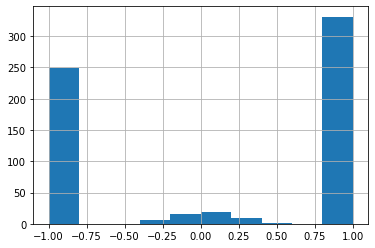

In [319]:
events.dropna(inplace=True)
events.ret.hist()

In [320]:
events

,ret,t1
timestamp,,
2019-07-06 19:51:00,0.209464,2019-07-06 23:51:00
2019-07-08 14:06:00,1.000000,2019-07-08 14:06:00
2019-07-09 10:13:00,-1.000000,2019-07-09 10:28:00
2019-07-10 15:04:00,-1.000000,2019-07-10 15:11:00
2019-07-11 23:27:00,1.000000,2019-07-12 00:23:00
...,...,...
2021-11-12 09:30:00,0.049270,2021-11-12 13:30:00
2021-11-12 16:03:00,1.000000,2021-11-12 18:00:00
2021-11-15 21:02:00,1.000000,2021-11-15 21:16:00


In [321]:
i=0

In [322]:
i-=1

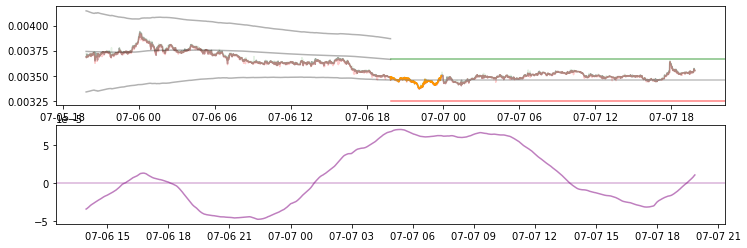

In [323]:
i+=1
item = events.index[i]
fig, [ax, ax1] = plt.subplots(figsize=(12,4), nrows=2)
ax.plot(df.loc[item-pd.Timedelta(days=1):item+pd.Timedelta(days=1)].high, c="green", alpha=0.1)
ax.plot(df.loc[item-pd.Timedelta(days=1):item+pd.Timedelta(days=1)].close, c="black", alpha=0.3)
ax.plot(df.loc[item-pd.Timedelta(days=1):item+pd.Timedelta(days=1)].low, c="red", alpha=0.1)

ax.plot(df.loc[item-pd.Timedelta(days=1):item].kc_upper, c="black", alpha=0.3)
ax.plot(df.loc[item-pd.Timedelta(days=1):item].kc_middle, c="black", alpha=0.3)
ax.plot(df.loc[item-pd.Timedelta(days=1):item].kc_lower, c="black", alpha=0.3)

ax.plot(df.loc[item:events.loc[item].t1].close, c="orange", alpha=1)

ax.plot(df.loc[item-pd.Timedelta(days=1):item+pd.Timedelta(days=1)].low, c="red", alpha=0.1)
ax.axhline(df.loc[item].kc_lower, c="gray", alpha=0.5, xmin=0.5)
ax.axhline(df.loc[item].kc_middle, c="green", alpha=0.5, xmin=0.5)
ax.axhline(df.loc[item].kc_lower-(df.loc[item].kc_middle-df.loc[item].kc_lower), c="red", alpha=0.5, xmin=0.5)

# ax1 = ax.twinx()
ax1.plot(df.loc[item-pd.Timedelta(days=1):item+pd.Timedelta(days=1)].macd, c="purple", alpha=0.5)
ax1.axhline(0, c="purple", alpha=0.3)
# ax.axhline(df.loc[item].close*events.loc[item].trgt+df.loc[item].close, c="green", alpha=0.2)
# ax.axhline(-df.loc[item].close*events.loc[item].trgt+df.loc[item].close, c="red", alpha=0.2)


## Previous metadata

In [324]:
# stats = ["k0", "k1", "k2", "k3", "k4", "k5", "k6", "m0", "m1", "m2", "p0", "p1", "p2", "t0", "t1", "t2", "t3",
#          "v0", "v1", "v2", "v3", "v4"]
# 
# stats = ["v0", "v1", "v2", "v3", "v4"]
stats = ["h0", "h1", "h2", "v0", "v1", "v2"]

In [379]:
def volume(df1, df2, df3):
    return sum(df1.volume)/sum(df2.volume)
def kc_mid(df1, df2, df3):
    return np.mean((df1.close-df1.kc_lower)/(df1.kc_upper-df1.kc_lower))
#     return np.mean((df1.close-df1.kc_lower)/(df1.kc_upper-df1.kc_lower))
def std_compare(df1, df2, df3):
    return np.std(df1.close)/df1.iloc[0].close
def v1(df1, df2, df3):
    return sum(df1.volume)/sum(df3.volume)
def v2(df1, df2, df3):
    return (np.std(df1.volume)-np.std(df2.volume))/df1.iloc[0].close
def k1(df1, df2, df3):
    return np.mean(df1.kc_upper-df1.kc_lower)/df1.iloc[0].close
def k2(df1, df2, df3):
    return np.mean(df2.kc_upper-df2.kc_lower)/df2.iloc[0].close
def s1(df1, df2, df3):
    return np.std(df2.close)/df2.iloc[0].close
def s2(df1, df2, df3):
    return np.std(df2.kc_upper-df2.kc_lower)/df2.iloc[0].close
def t0(df1, df2, df3):
    return (df1.iloc[-1].kc_middle-df1.iloc[0].kc_middle)/df1.iloc[0].close
def t1(df1, df2, df3):
    return (df2.iloc[-1].kc_middle-df2.iloc[0].kc_middle)/df2.iloc[0].close
def t2(df1, df2, df3):
    return (df3.iloc[-1].kc_middle-df3.iloc[0].kc_middle)/df3.iloc[0].close
def k3(df1, df2, df3):
    return np.mean((df2.close-df2.kc_lower)/(df2.kc_upper-df2.kc_lower))
def k4(df1, df2, df3):
    return np.mean((df3.close-df3.kc_lower)/(df3.kc_upper-df3.kc_lower))
def k5(df1, df2, df3):
    return ((df1.kc_upper[-1]-df1.kc_lower[-1])-(df1.kc_upper[0]-df1.kc_lower[0]))/df1.iloc[0].close
def k6(df1, df2, df3):
    return ((df2.kc_upper[-1]-df2.kc_lower[-1])-(df2.kc_upper[0]-df2.kc_lower[0]))/df2.iloc[0].close
def k7(df1, df2, df3):
    return ((df3.kc_upper[-1]-df3.kc_lower[-1])-(df3.kc_upper[0]-df3.kc_lower[0]))/df3.iloc[0].close
def v3(df1, df2, df3):
    return sum(df1.loc[df1.index[-1]-pd.Timedelta(hours=12):].volume)/sum(df1.volume)

In [1424]:
def k0(df1, df2, df3):
    return np.mean((df1.close-df1.kc_lower)/(df1.kc_upper-df1.kc_lower))
def k1(df1, df2, df3):
    return np.mean((df2.close-df2.kc_lower)/(df2.kc_upper-df2.kc_lower))
def k2(df1, df2, df3):
    return np.mean((df3.close-df3.kc_lower)/(df3.kc_upper-df3.kc_lower))
def k3(df1, df2, df3):
    df1 = df1.loc[df1.index[-1]-pd.Timedelta(hours=12):]
    return np.mean((df1.close-df1.kc_lower)/(df1.kc_upper-df1.kc_lower))
def k4(df1, df2, df3):
    return df1.loc[df1.high<df1.kc_middle].shape[0]/df1.shape[0]
def k5(df2, df1, df3):
    return df1.loc[df1.high<df1.kc_middle].shape[0]/df1.shape[0]
def k6(df3, df2, df1):
    return df1.loc[df1.high<df1.kc_middle].shape[0]/df1.shape[0]
    

# def m0(df2, df1, df3):
#     return df1.macd[-1]/df1.iloc[-1].close
# def m1(df2, df1, df3):
#     return (max(df1.macd)-min(df1.macd))/df1.iloc[-1].close
# def m2(df1, df2, df3):
#     return (max(df2.macd)-min(df2.macd))/df2.iloc[-1].close
def m0(df2, df1, df3):
    return min(df1.macd)/max(df1.macd)
def m1(df2, df1, df3):
    return min(df2.macd)/max(df2.macd)
def m2(df1, df2, df3):
    return min(df1.macd)/df1.iloc[-1].close

# def p0(df3, df2, df1):
#     return df3[df3.low<df3.kc_lower].shape[0]/df3.shape[0]
# def p1(df3, df2, df1):
#     return df3[df3.high>df3.kc_upper].shape[0]/df3.shape[0]
def p0(df1, df2, df3):
    return df3[(df3.high>df3.kc_upper) | (df3.low<df3.kc_lower)].shape[0]/df3.shape[0]
def p1(df1, df3, df2):
    return df3[(df3.high>df3.kc_upper) | (df3.low<df3.kc_lower)].shape[0]/df3.shape[0]
def p2(df3, df2, df1):
    return df3[(df3.high>df3.kc_upper) | (df3.low<df3.kc_lower)].shape[0]/df3.shape[0]

def t0(df1, df2, df3):
    return (df1.iloc[-1].kc_middle-df1.iloc[0].kc_middle)/df1.iloc[-1].close
def t1(df1, df2, df3):
    return (df2.iloc[-1].kc_middle-df2.iloc[0].kc_middle)/df2.iloc[-1].close
def t2(df1, df2, df3):
    return (df3.iloc[-1].kc_middle-df3.iloc[0].kc_middle)/df3.iloc[-1].close
def t3(df1, df2, df3):
    return (max(df2.kc_middle)-min(df2.kc_middle))/df2.iloc[0].close

def v0(df1, df2, df3):
    df_1 = df1.loc[df1.index[-1]-pd.Timedelta(minutes=5):]
    df_2 = df1.loc[df1.index[-1]-pd.Timedelta(minutes=30):]
    return sum(df_1.volume)/sum(df_2.volume)
def v1(df1, df2, df3):
    df_1 = df1.loc[df1.index[-1]-pd.Timedelta(minutes=30):]
    df_2 = df1.loc[df1.index[-1]-pd.Timedelta(hours=4):]
    return sum(df_1.volume)/sum(df_2.volume)
def v2(df1, df2, df3):
    df_1 = df1.loc[df1.index[-1]-pd.Timedelta(hours=4):]
    df_2 = df1.loc[df1.index[-1]-pd.Timedelta(hours=12):]
    return sum(df_1.volume)/sum(df_2.volume)
def v3(df1, df2, df3):
    df_1 = df1.loc[df1.index[-1]-pd.Timedelta(minutes=1):]
    df_2 = df1.loc[df1.index[-1]-pd.Timedelta(minutes=5):]
    return sum(df_1.volume)/sum(df_2.volume)
def v4(df1, df2, df3):
    return sum(df1.volume)/sum(df3.volume)

In [325]:
def v0(df1, df2, df3):
    df_1 = df1.loc[df1.index[-1]-pd.Timedelta(hours=1):]
    df_2 = df1.loc[df1.index[-1]-pd.Timedelta(hours=2):]
    return sum(df_1.volume)/sum(df_2.volume)
def v1(df1, df2, df3):
    df_1 = df1.loc[df1.index[-1]-pd.Timedelta(hours=2):]
    df_2 = df1.loc[df1.index[-1]-pd.Timedelta(hours=4):]
    return sum(df_1.volume)/sum(df_2.volume)
def v2(df1, df2, df3):
    df_1 = df1.loc[df1.index[-1]-pd.Timedelta(hours=4):]
    return sum(df_1.volume)/sum(df1.volume)
def h0(df1, df2, df3):
    df_1 = df1.loc[df1.index[-1]-pd.Timedelta(hours=1):]
    df_2 = df1.loc[df1.index[-1]-pd.Timedelta(hours=2):]
    return (np.mean(df_1.high-df_1.low)/np.mean(df_2.high-df_2.low))
def h1(df1, df2, df3):
    df_1 = df1.loc[df1.index[-1]-pd.Timedelta(hours=2):]
    df_2 = df1.loc[df1.index[-1]-pd.Timedelta(hours=4):]
    return np.mean(df_1.high-df_1.low)/np.mean(df_2.high-df_2.low)
def h2(df1, df2, df3):
    df_1 = df1.loc[df1.index[-1]-pd.Timedelta(minutes=10):]
    df_2 = df1.loc[df1.index[-1]-pd.Timedelta(minutes=60):]
    return np.mean(df_1.high-df_1.low)/np.mean(df_2.high-df_2.low)

In [326]:
# funcs = [k0, k1, k2, k3, k4, k5, k6, m0, m1, m2, p0, p1, p2, t0, t1, t2, t3,
#          v0, v1, v2, v3, v4]
funcs = [h0, h1, h2, v0, v1, v2]

In [327]:
e = get_kc_events(df, events, stats, funcs)

In [328]:
e["ret"] = events.ret

In [329]:
def m(s):
    return np.mean(s)
def s(s):
    return np.std(s)
print(stats)

['h0', 'h1', 'h2', 'v0', 'v1', 'v2']


0.5482, std: 0.1737
0.5527, std: 0.1733


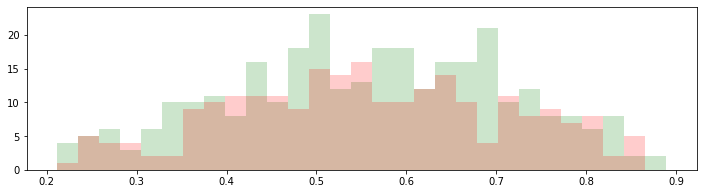

In [330]:
x = e.v1
y = e.reindex(x.index).ret
fig, ax = plt.subplots(figsize=(12,3))
bins = np.linspace(m(x)-2*s(x), m(x)+2*s(x), 30)
ax.hist(x=x[y==1], bins=bins, color="green", alpha=0.2)
ax.hist(x=x[y==-1], bins=bins, color="red", alpha=0.2);
print(f"{round(np.mean(x[y==1]), 4)}, std: {round(np.std(x[y==1]), 4)}")
print(f"{round(np.mean(x[y==-1]), 4)}, std: {round(np.std(x[y==-1]), 4)}")

In [331]:
print(f"mean:{round(m(x), 4)}, std: {round(np.std(x), 4)}")

mean:0.5504, std: 0.1693


In [332]:
i = -1

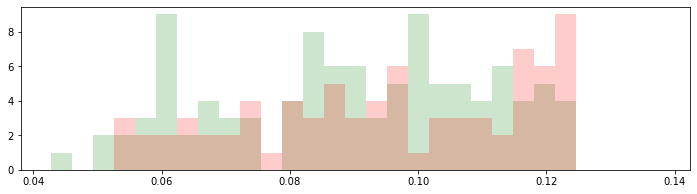

In [333]:
i +=1
base = e[ (e.index==e.index) \
         & (e.v2<m(e.v2)-0.5*s(e.v2)) \
#          & (e.h0>m(e.h0)) \
#          & (e.h2>m(e.h2)) \
#          & (e.v3<m(e.v3)) \
#         & ((e.t0<m(e.t0)+s(e.t0)) | (e.t0>m(e.t0)-s(e.t0))) \
#          & ((e.t1<m(e.t1)+s(e.t1)) | (e.t1>m(e.t1)-s(e.t1))) \
#          & ((e.t2<m(e.t2)+s(e.t2)) | (e.t2>m(e.t2)-s(e.t2))) \
#         & (e.p1>m(e.p1))\
#         & (e.k6>m(e.k6)+s(e.k6))\
#         & (e.k7>m(e.k7)+s(e.k7))\
        ]

# base = e[ (e.index==e.index) \
#          & (e.p1>m(e.p1))\
#          & (e.v0<m(e.v0))\
# #         & (e.v1<m(e.v1)+s(e.v1)) & (e.v1>m(e.v1)-s(e.v1)) \
#         ]

# x = base[stats[i]]
x = base.v2

y = base.ret
fig, ax = plt.subplots(figsize=(12,3))

bins = np.linspace(m(x)-2*s(x), m(x)+2*s(x), 30)
ax.hist(x=x[y==1], bins=bins, color="green", alpha=0.2)
ax.hist(x=x[y==-1], bins=bins, color="red", alpha=0.2);

# ax.axhline(0, c="gray", alpha=0.3)

# ax.plot(average_line(x, y, 50))

In [334]:
i = 0 if i>=len(stats) else i
print(f"{stats[i]}: mean:{round(m(e[stats[i]]), 4)}, std: {round(np.std(e[stats[i]]), 4)}")

h0: mean:1.1865, std: 0.325


In [335]:
print(f"{round(np.mean(y)*100, 2)}%, for {len(y)} events, min: {int(np.ceil(len(df)/10000))}")


13.78%, for 203 events, min: 125


In [336]:
print(f"{round((sum(y[y>0])/(sum(abs(y))))*100, 2)}% winrate")


57.32% winrate


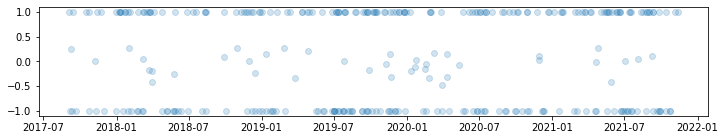

In [239]:
fig, ax = plt.subplots(figsize=(12,2))
y_ = events.reindex(x.index).ret
x_ = x.index
ax.scatter(x=x_, y=y_, alpha=0.2)

In [240]:
y_

timestamp
2017-09-03 13:37:00    1.000000
2017-09-05 00:17:00   -1.000000
2017-09-09 17:33:00    0.254864
2017-09-10 02:35:00   -1.000000
2017-09-12 23:10:00    1.000000
                         ...   
2021-10-13 14:01:00    1.000000
2021-10-22 14:00:00   -1.000000
2021-10-23 05:05:00   -1.000000
2021-11-06 07:27:00    1.000000
2021-11-12 01:21:00    1.000000
Name: ret, Length: 309, dtype: float64

## SAVED STRATS

In [1081]:
i=400

In [1082]:
i+=1
item = y_.index[i]
fig, [ax, ax1] = plt.subplots(figsize=(12,4), nrows=2)
ax.plot(df.loc[item-pd.Timedelta(hours=1):item+pd.Timedelta(hours=1)].high, c="green", alpha=0.1)
ax.plot(df.loc[item-pd.Timedelta(hours=1):item+pd.Timedelta(hours=1)].close, c="black", alpha=0.3)
ax.plot(df.loc[item-pd.Timedelta(hours=1):item+pd.Timedelta(hours=1)].low, c="red", alpha=0.1)

ax.plot(df.loc[item-pd.Timedelta(hours=1):item].kc_upper, c="black", alpha=0.3)
ax.plot(df.loc[item-pd.Timedelta(hours=1):item].kc_middle, c="black", alpha=0.3)
ax.plot(df.loc[item-pd.Timedelta(hours=1):item].kc_lower, c="black", alpha=0.3)

ax.plot(df.loc[item:events.loc[item].t1].close, c="orange", alpha=1)

ax.plot(df.loc[item-pd.Timedelta(hours=1):item+pd.Timedelta(hours=1)].low, c="red", alpha=0.1)
ax.axhline(df.loc[item].kc_lower, c="gray", alpha=0.5, xmin=0.5)
ax.axhline(df.loc[item].kc_middle, c="green", alpha=0.5, xmin=0.5)
ax.axhline(df.loc[item].kc_lower-(df.loc[item].kc_middle-df.loc[item].kc_lower), c="red", alpha=0.5, xmin=0.5)

# ax1 = ax.twinx()
ax1.plot(df.loc[item-pd.Timedelta(hours=1):item+pd.Timedelta(hours=1)].macd, c="purple", alpha=0.5)
ax1.axhline(0, c="purple", alpha=0.3)
# ax.axhline(df.loc[item].close*events.loc[item].trgt+df.loc[item].close, c="green", alpha=0.2)
# ax.axhline(-df.loc[item].close*events.loc[item].trgt+df.loc[item].close, c="red", alpha=0.2)


IndexError: index 401 is out of bounds for axis 0 with size 85

## Research to see if macd should be done on minutely or hourly, seems like hourly

In [7]:
df["macd"] = ta.macd(df.close, fast=3*60, slow=10*60, signal=16*60, result="hist")
dfh["macd"] = ta.macd(dfh.close, result="hist")

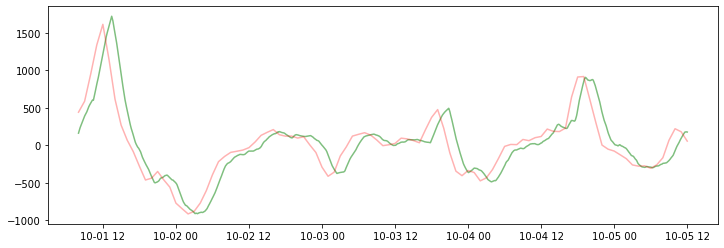

In [13]:
a = dfh.index[-1000]
b = dfh.index[-900]
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(df.loc[a:b].macd, c="green", alpha=0.5)
ax.plot(dfh.loc[a:b].macd, c="red", alpha=0.3)

In [14]:
df.loc[a]

open      44788.420000
high      44845.000000
low       44773.000000
close     44783.180000
volume       85.944880
macd        162.685982
Name: 2021-10-01 08:00:00, dtype: float64

In [15]:
dfh.loc[a]

open      44788.420000
high      44999.000000
low       44700.000000
close     44945.800000
volume     2953.837140
macd        442.023187
Name: 2021-10-01 08:00:00, dtype: float64

In [ ]:
e[ (e.k0==e.k0) \
        & (e.p2>m(e.p2))
#         & (e.p1>m(e.p1))
#         & (e.p0>m(e.p0))
#         & (e.k6>m(e.k6)+s(e.k6))\
#         & (e.k7>m(e.k7)+s(e.k7))\
        ]

In [ ]:
[ (e.index==e.index) \
        & (e.p2>m(e.p2)) \
        & (e.k3<m(e.k3)) \
#          & (e.k3>m(e.k3)-s(e.k3))
#         & (e.m0>m(e.m0))
#         & (e.k6>m(e.k6)+s(e.k6))\
#         & (e.k7>m(e.k7)+s(e.k7))\
        ]

In [ ]:
e[ (e.index==e.index) \
        & (e.p2>0.5*m(e.p2)) \
        & (e.k3<m(e.k3)) \
#          & (e.k3>m(e.k3)-s(e.k3))
#         & (e.m0>m(e.m0))
#         & (e.k6>m(e.k6)+s(e.k6))\
#         & (e.k7>m(e.k7)+s(e.k7))\
        ]

In [ ]:
e[ (e.index==e.index) \
        & ((e.m2<m(e.m2)-s(e.m2)) \
        | (e.m1<m(e.m1)-s(e.m1))) \
        & (e.t1>m(e.t1)-s(e.t1)) \
#         & (e.m0>m(e.m0))
#         & (e.k6>m(e.k6)+s(e.k6))\
#         & (e.k7>m(e.k7)+s(e.k7))\
        ]

In [ ]:
e[ (e.index==e.index) & ((e.t0<m(e.t0)+s(e.t0)) | (e.t0>m(e.t0)-s(e.t0))) & ((e.t1<m(e.t1)+s(e.t1)) | (e.t1>m(e.t1)-s(e.t1))) & (e.p1>m(e.p1))]
